In [ ]:
:sccache 1
// Skip this or run `cargo install sccache`

In [2]:
:dep z3tracer = { path = "../../z3tracer", features = ["report"] }
// TODO: change the path to your local path to z3tracer.

In [3]:
:dep plotly

In [4]:
:efmt {:?}

Error format: {:?} (errors must implement std::fmt::Debug)


In [ ]:
:last_error_json
// BUG WORKAROUND: In case of mysteriously truncated error 'consider importing this struct', run the command above again
// to print a detailed error and find the import that is actually missing.
//
// See also :help for more useful commands

In [5]:
use z3tracer::{syntax::*, model::*, report::*};
use std::collections::*;
use std::str::FromStr;
use plotly::*;
use plotly::common::*;
use plotly::layout::*;

In [6]:
// Process some input file obtained with `z3 trace=true proof=true ..`
let model = process_file(ModelConfig::default(), std::path::Path::new("../tests/data/file1.log"))?;

In [7]:
// Compute top instantiated terms.
let mut top = model.most_instantiated_terms();
top.len()

66

In [8]:
// Peek at the 20th top elements
IntoIterSorted::from(top.clone()).take(20).collect::<Vec<_>>()

[(7903, basic#), (2955, datatype#85), (2955, datatype#82), (1863, datatype#), (1114, arith#), (769, datatype#59), (331, #4429!9), (304, #4328), (232, datatype#47), (224, #20151!10), (126, #20468!5), (120, #4351!1), (119, #23065!1), (119, #4347!1), (115, #4337), (100, #23092!1), (99, #23078!2), (97, datatype#53), (93, datatype#143), (93, datatype#140)]

In [9]:
// Retrieve the "timestamps" at which instantiations occur for each of the top terms.
let instantiation_times = IntoIterSorted::from(model.most_instantiated_terms()).map(|(_count, id)| {
    let mut timestamps = model.term_data(&id).unwrap().instantiation_timestamps.clone();
    timestamps.sort();
    let name = match model.term(&id).unwrap() { Term::Quant { name, .. } | Term::Builtin { name: Some(name) } => name, _ => "??" };
    (name.to_string(), timestamps)
}).collect::<Vec<_>>();

In [10]:
// Maximum timestamp (i.e. currently, the number of lines in the Z3 log)
let max_ts = model.processed_logs();
max_ts

443166

In [11]:
// Maximum number of instantiations for the top term.
let max_count = top.peek().unwrap().0;
max_count

7903

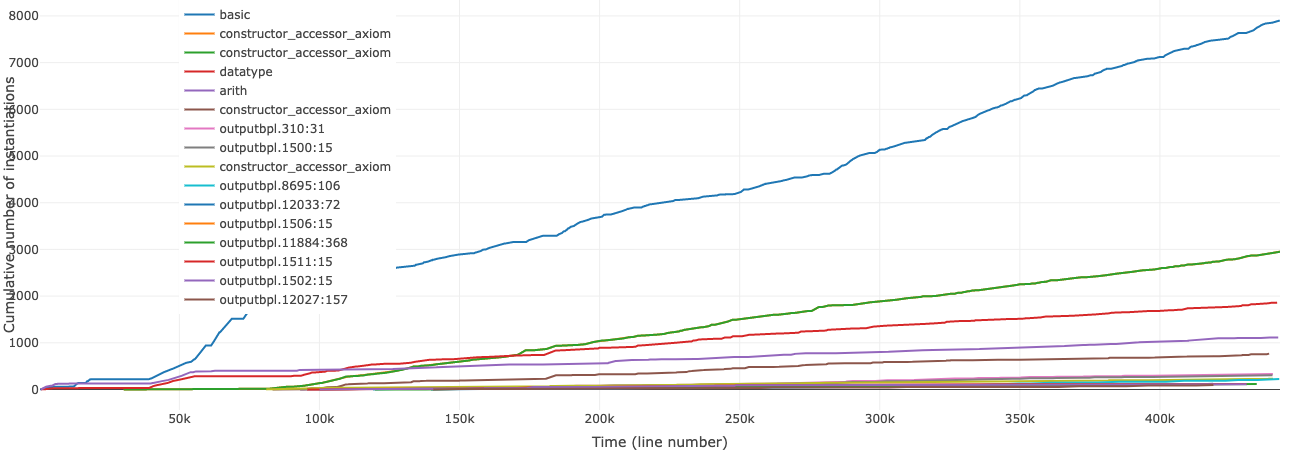

In [12]:
let layout = Layout::new()
    .x_axis(Axis::new().title(Title::new("Time (line number)")))
    .y_axis(Axis::new().title(Title::new("Cumulative number of instantiations")))
    .margin(Margin::new().top(0).bottom(40).left(40).right(10))
    .legend(Legend::new().x(0.2).y(1.0).orientation(Orientation::Vertical).x_anchor(Anchor::Center));

let mut plot = Plot::new();
plot.set_layout(layout);

for (name, values) in instantiation_times.iter().take(16) {
    let (ys, xs) : (Vec<_>, Vec<_>) = values.iter().cloned().enumerate().unzip();
    let trace = Scatter::new(xs, ys).name(name).mode(Mode::Lines);
    plot.add_trace(trace);
}

plot.lab_display();

In [13]:
// Top instantiated quantified term.
model.id2s(&top.peek()?.1)

"basic"

In [14]:
// Final counter and `Ident` value for the top term.
top.peek()?

(7903, basic#)

In [15]:
// Introspect a particular term, given by handle.
// Note that the version number `!9` was added during parsing for disambiguation and is not present in the original log file.
model.term(&Ident::from_str("#4429!9")?)?

Quant { name: "outputbpl.310:31", params: 2, triggers: [#284], body: #4443, var_names: Some([VarName { name: Symbol("v2"), sort: Symbol("T@$Value") }, VarName { name: Symbol("v1"), sort: Symbol("T@$Value") }]) }

In [16]:
let qt = model.term(&Ident::from_str("#4429!9")?)?.clone();

In [17]:
model.id2s(&Ident::from_str("#257!1")?)

"($IsEqual_stratified _1 _0)"

In [18]:
use z3tracer::syntax::Term::Quant;

(match qt { Term::Quant { triggers, .. } => Some(model.id2s(&triggers[0])), _ => None })?

"(pattern ($IsEqual_stratified _1 _0))"